# BigMart Sales Project


## Problem Statement
The Data Scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.

Business Goal : Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

--------------------------------------------------------------------------------------------------------

## IMPORTING LIBRARIES





In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

## LOADING THE DATA AND PREPROCESSING



In [45]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('Train.csv')

In [46]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Features Description:

- Numerical features:
  - Item_Weight : Weight of the product or item.
  - Item_Visibility : The % of the total display area of all products in a store allocated to the particular product.
  - Item_MRP : Maximum Retail Price (list price) of the product
  - Outlet_Establishment_Year : The year in which the store was established.
  - Item_Outlet_Sales : sales of the product in a particular store. This is the target variable to be predicted.

- Categorical features:
  - Item_Identifier : Unique product ID (we would want to drop this column later)
  - Item_Fat_Content : Whether the product is low, fat or not
  - Item_Type : The category to which the product belongs.
  - Outlet_Identifier : Unique store ID
  - Outlet_Size : The size of the store in terms of ground area covered.
  - Outlet_Location_Type : The type of city in which the store is located.
  - Outlet_Type : Whether the outlet is just a grocery store or some sort of supermarket.

In [47]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [48]:
# getting some information about thye dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:

  - Item_Identifier
  - Item_Fat_Content
  - Item_Type
  - Outlet_Identifier
  - Outlet_Size
  - Outlet_Location_Type
  - Outlet_Type

In [49]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Handling Missing Values

In [50]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

np.float64(12.857645184135976)

In [51]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

In [52]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [53]:
mode_of_Outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [54]:
miss_values = big_mart_data['Outlet_Size'].isnull()   

In [55]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [56]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [57]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Data Analysis

In [58]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


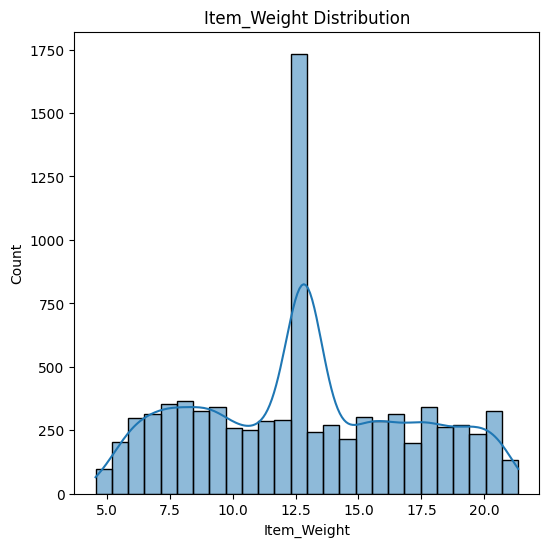

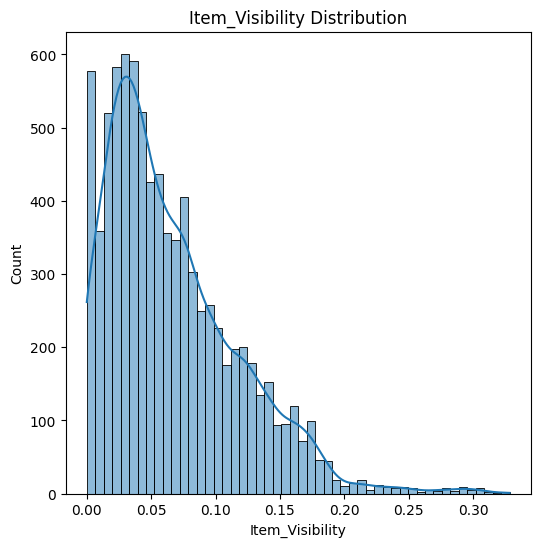

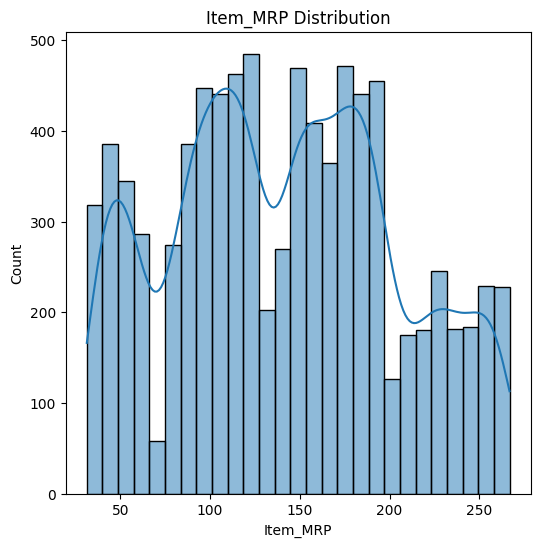

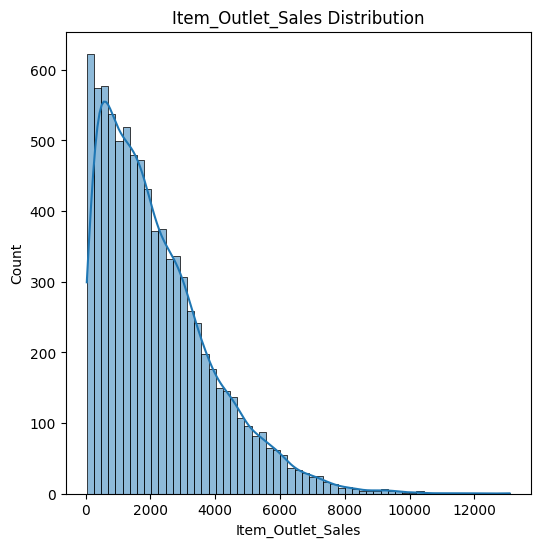

In [59]:
#Plot histplot for numerical columns
cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
for col in cols:
    plt.figure(figsize=(6, 6))
    sns.histplot(big_mart_data[col], kde=True, palette='muted')
    plt.title(f'{col} Distribution')  # Dynamically set the title based on the column
    plt.show()


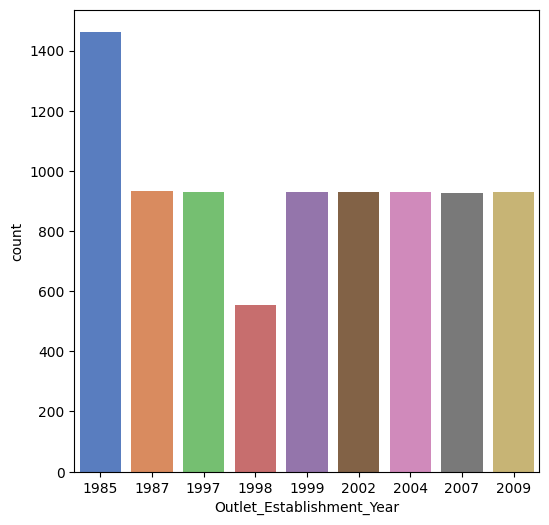

In [60]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data , palette='muted')
plt.show()

Categorical Features

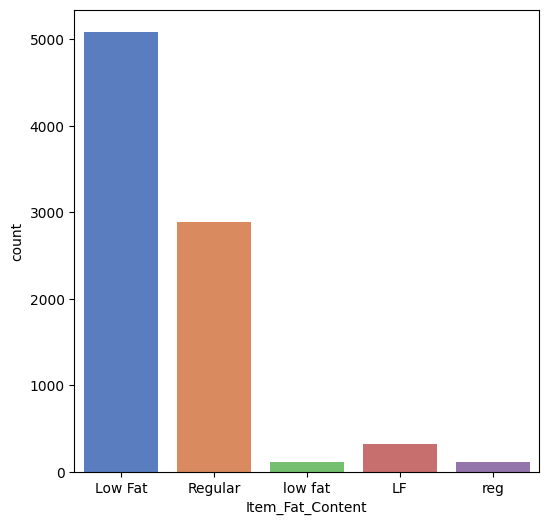

In [61]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data , palette='muted')
plt.show()

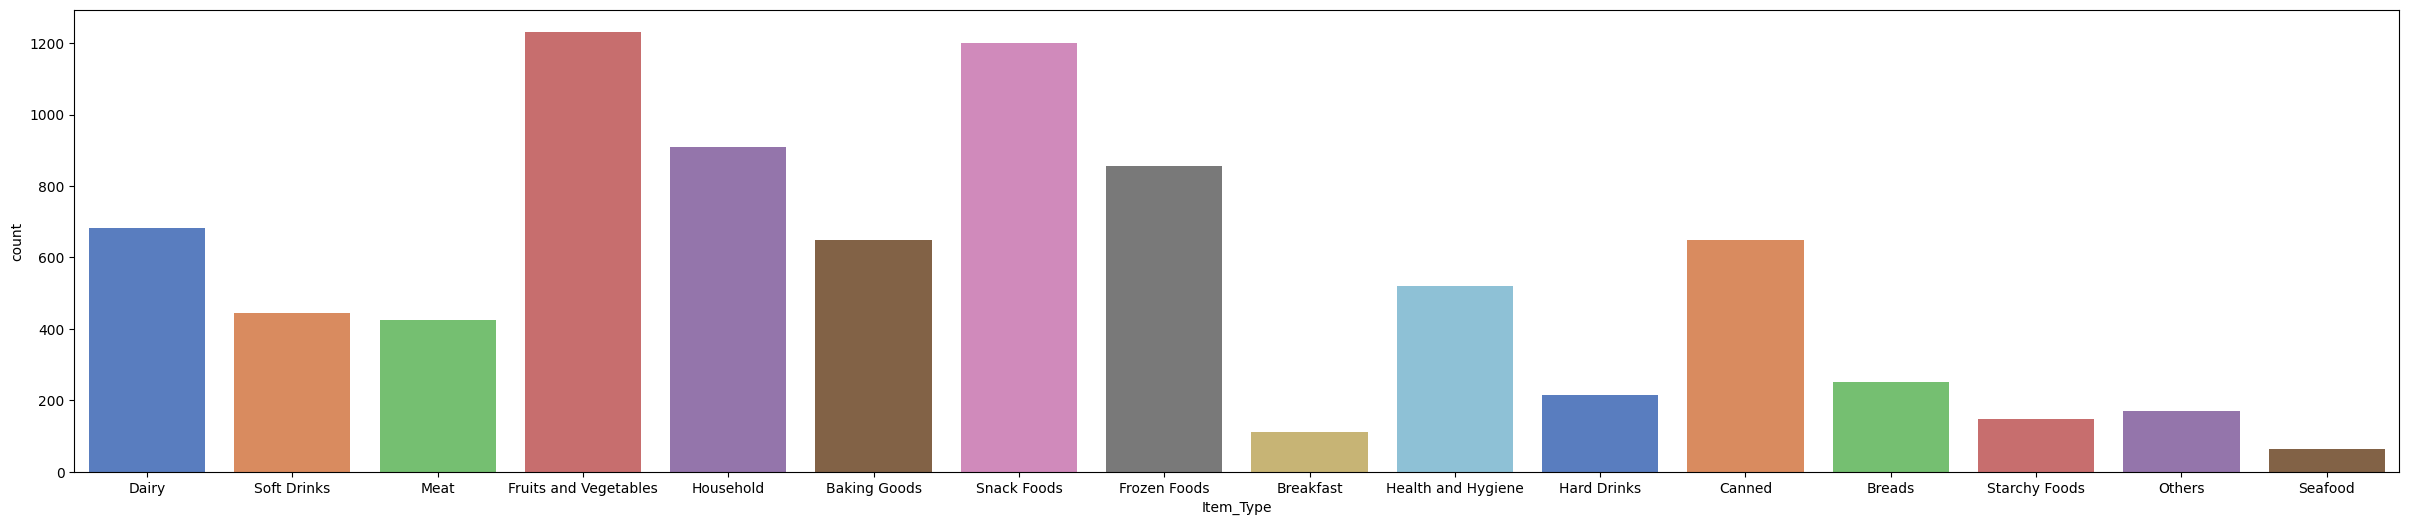

In [62]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data , palette='muted')
plt.show()

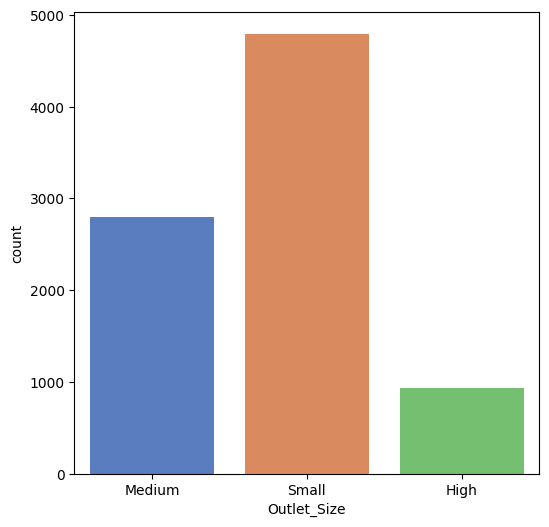

In [63]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data , palette='muted')
plt.show()

## Data Pre-Processing

In [64]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [65]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

In [66]:
#handle Item_Fat_Content column categories with replacement
big_mart_data['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

In [67]:
big_mart_data['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

## Splitting features and Target

In [68]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

## Splitting the data into Training data & Testing Data

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [70]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


## Label Encoding

In [71]:
encoder = LabelEncoder()

In [72]:
X_train['Item_Identifier'] = encoder.fit_transform(X_train['Item_Identifier'])
X_test['Item_Identifier'] = encoder.transform(X_test['Item_Identifier'])

X_train['Item_Fat_Content'] = encoder.fit_transform(X_train['Item_Fat_Content'])
X_test['Item_Fat_Content'] = encoder.transform(X_test['Item_Fat_Content'])

X_train['Item_Type'] = encoder.fit_transform(X_train['Item_Type'])
X_test['Item_Type'] = encoder.transform(X_test['Item_Type'])

X_train['Outlet_Identifier'] = encoder.fit_transform(X_train['Outlet_Identifier'])
X_test['Outlet_Identifier'] = encoder.transform(X_test['Outlet_Identifier'])

X_train['Outlet_Size'] = encoder.fit_transform(X_train['Outlet_Size'])
X_test['Outlet_Size'] = encoder.transform(X_test['Outlet_Size'])

X_train['Outlet_Location_Type'] = encoder.fit_transform(X_train['Outlet_Location_Type'])
X_test['Outlet_Location_Type'] = encoder.transform(X_test['Outlet_Location_Type'])

X_train['Outlet_Type'] = encoder.fit_transform(X_train['Outlet_Type'])
X_test['Outlet_Type'] = encoder.transform(X_test['Outlet_Type'])



In [73]:
X_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1112,496,12.857645,0,0.099747,6,75.2328,5,1985,1,2,3
1751,382,12.150000,0,0.131446,5,246.8460,7,2002,2,1,1
7648,1207,5.800000,0,0.131221,4,87.8172,7,2002,2,1,1
7362,1415,17.000000,0,0.087388,8,125.0730,0,1998,2,2,0
5332,910,12.857645,0,0.009585,5,102.5016,4,1985,2,0,0


## Machine Learning Model Training

XGBoost Regressor

In [74]:
regressor = XGBRegressor()

In [75]:
regressor.fit(X_train, Y_train);

In [76]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [77]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [78]:
print('R Squared value = ', r2_train)

R Squared value =  0.8762174618111388


In [79]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [80]:
# R squared Value
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [81]:
print('R Squared value = ', r2_test)

R Squared value =  0.5017253991620692
